In [153]:
import pandas as pd
from os import listdir
from pandas.errors import EmptyDataError
from unidecode import unidecode
import seaborn as sns
import re
from wordcloud import WordCloud
from gensim.models import Word2Vec
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial import distance

sns.set(
    rc = {
        'figure.figsize': (10, 8)
    },
    style = 'darkgrid'
)

# Dictionaries

In [8]:
grouping_orders = {
    "website": {
        "columns_before": ['website', 'sentiment'],
        "groupby": ["website"],
        "columns_after": ['fakt', 'gazeta', 'wyborcza'] 
    },
    "brand": {
        "columns_before": ['brand', 'sentiment'],
        "groupby": ["brand"],
        "columns_after": ['agora', 'ringier'] 
    },
    "country": {
        "columns_before": ['country', 'sentiment'],
        "groupby": ["country"],
        "columns_after": ['de/ch', 'pl'] 
    }
}

In [9]:
brand_keys = {
    "pl": {
        "agora": ['wyborcza', 'gazeta']
    },
    "de/ch": {
        "ringier": ['fakt', 'onet', 'newsweek']
    },
    'us': {
        "discovery": ['tvn']
    }
}

In [10]:
osoba = ['ideał', ''] # wzór, wróg, nieprzyjaciel
partia = ['postęp', 'nieudolność'] # rozwój, dobrobyt, 
poglad = ['swoboda', 'reżim'] # chaos, totalitaryzm, racjonalizm
kraj = ['sojusznik', 'wróg'] # ostoja, oaza, 
keyword_reference_words = {
    'sąd': ['', ''],
    'imigranci': ['przyjaciele', 'wrogowie'],
    'ekologia': ['', ''],
    'emigracja': ['', ''],
    'pis': partia,
    'platforma': partia,
    'duda': osoba,
    'morawiecki': osoba,
    'szydło': osoba,
    'kaczyński': osoba,
    'kwaśniewski': osoba,
    'lewica': poglad,
    'prawica': poglad,
    'lgbt': ['', ''],
    'europejska': ['wspólnota', 'podział'], # wspólnota, rozłam
    'rosja': kraj,
    'stany': kraj,
    'premier': osoba,
    'prezydent': osoba,
    'opozycja': partia,
    'rząd': partia,
    'sejm': partia,
    'polska': ['dom', ''],
    'putin': ['sojusznik', 'wróg'],
    'trump': ['sojusznik', 'wróg'],
    'ukraina': kraj,
    'media': ['', ''],
    'bank': ['', ''],
    'niemcy': kraj,
    'papież': osoba,
    'kościół': ['', ''],
    'korwin': osoba,
    'rydzyk': osoba,
    'feminizm': ['', ''],
    'leszek+miller': osoba,
}

In [11]:
decoder = {
    '%B1': 'ą',
    '%BF': 'ż',
    '%B3': 'ł',
    '%B6': 'ś',
    '%F1': 'ń',
    '%F3': 'ó'
}
with open('keywords', 'r') as f:
    raws = f.read().split('\n')
keyword_dict = {}
for raw in raws:
    tmp_keyword = raw
    for d1, d2 in decoder.items():
        tmp_keyword = tmp_keyword.replace(d1, d2)
    keyword_dict[tmp_keyword] = ''

In [12]:
keyword_regex = {
    'pis': r"\Dpis\D|prawo i sprawiedliwość"
}

# Read data

## Wyborcza

In [13]:
wyborcza_articles = []
for filename in listdir('data/wyborcza/articles'):
    try:
        wyborcza_articles.append(pd.read_csv('data/wyborcza/articles/'+filename, header = None))
    except EmptyDataError:
        pass # empty file
wyborcza_articles = pd.concat(wyborcza_articles)
wyborcza_articles.columns = ['url', 'title', 'short', 'long', 'img', 'com']
wyborcza_articles['short'] = wyborcza_articles['short'].str.replace(r'(.|..)\n', '')
wyborcza_articles = wyborcza_articles[~wyborcza_articles['long'].str.contains('W odpowiedzi do @', na = False) == True]
wyborcza_articles = wyborcza_articles[['title', 'short', 'long']]
wyborcza_articles = wyborcza_articles.dropna()
wyborcza_articles = wyborcza_articles[wyborcza_articles['title'].duplicated() == False]
wyborcza_articles = wyborcza_articles[wyborcza_articles['short'] != '0']
wyborcza_articles['website'] = 'wyborcza'
wyborcza_articles['brand'] = 'agora'
wyborcza_articles['country'] = 'pl'

In [66]:
wyborcza_articles = wyborcza_articles[
    (
        wyborcza_articles['title'] + ' ' +
        wyborcza_articles['long'] + ' ' +
        wyborcza_articles['short'] 
    ).str.contains(r""+"|".join(list(keyword_reference_words.keys())).replace('+', ' ')) == True
]

In [67]:
len(wyborcza_articles)

36416

In [15]:
wyborcza_articles.sample(5).head(5)

,title,short,long,website,brand,country
501,Piłkarski majstersztyk w Gdyni. Arka rozbiła w...,Posiłkiem godnym niejednej gwiazdki Michelin u...,Mecz – palce lizać. Gdy takie stwierdzenie pad...,wyborcza,agora,pl
498,Umberto Eco w Łodzi - o teoriach spiskowych i ...,Doktor honoris causa Uniwersytetu Łódzkiego sp...,"Prof. Piotr Salwa, italianista, literaturoznaw...",wyborcza,agora,pl
561,Dajcie nam się urządzić,"Nie musi być tak, jak jest teraz - pod tym has...",Europa nie ma wyrazistego przywódcy. Ale czy r...,wyborcza,agora,pl
325,Złoty medalista z Aten odwiedził rodzinne strony,Jacy z nas Niemcy. My jesteśmy Ślązokami i ten...,"Nowe Chechło, wioska koło Świerklańca. Z jedne...",wyborcza,agora,pl
294,"""Czego nie powie ci lekarz?"" Tłumy na spotkani...",Bilety na niedzielne spotkanie w Poznaniu z wr...,„Tego nie możecie przegapić!” – reklamował mie...,wyborcza,agora,pl


## Gazeta

In [16]:
gazeta_articles = []
for filename in listdir('data/gazeta/articles'):
    try:
        gazeta_articles.append(pd.read_csv('data/gazeta/articles/'+filename, header = None))
    except EmptyDataError:
        pass # empty file
gazeta_articles = pd.concat(gazeta_articles)
gazeta_articles.columns = ['url', 'title', 'short', 'long', 'img', 'com']
gazeta_articles = gazeta_articles[['title', 'short', 'long']]
gazeta_articles = gazeta_articles[gazeta_articles['title'].duplicated() == False]
gazeta_articles['website'] = 'gazeta'
gazeta_articles['brand'] = 'agora'
gazeta_articles['country'] = 'pl'

In [17]:
len(gazeta_articles)

12075

In [18]:
gazeta_articles.sample(5).head()

,title,short,long,website,brand,country
84,"Park Praski: przewróciło się drzewo, zginęło 6...",Pod koniec sierpnia drzewo runęło na matkę z n...,"Do tragedii doszło 20 sierpnia, gdy rodzice wr...",gazeta,agora,pl
116,Bardzo pechowy Off Festival. Plaga odwoływanyc...,Zakończyła się kolejna edycja Off Festiwalu. Z...,Tegoroczny katowicki Off Festiwal był bardzo p...,gazeta,agora,pl
8,Czym jest przedtreningówka? Jak wybrać? Rozwie...,Przedtreningówka to nic innego jak odżywka prz...,Przedtreningówka – co to?\nRynek suplementów d...,gazeta,agora,pl
3,Gwałtowna burza w stolicy: zalało Sejm i Złote...,Wieczorem nad Warszawą doszło do oberwania chm...,Warszawa: Gradowa burza przestawia samochód\n\...,gazeta,agora,pl
102,Komisje wyborcze Sępopol - 2015,Lista obwodowych komisji wyborczych w mieście ...,Obwodowa komisja wyborcza nr 1\nGmina: gm. Sęp...,gazeta,agora,pl


## Fakt

In [19]:
fakt_articles = []
for filename in listdir('data/fakt/articles'):
    tmp_df = pd.read_csv('data/fakt/articles/'+filename, header = None)
    tmp_df.columns = ['url', 'title', 'short', 'long', 'img', 'com',]
    tmp_df[filename] = 1
    tmp_df[filename] = tmp_df[filename].fillna(0)
    fakt_articles.append(tmp_df)
fakt_articles = pd.concat(fakt_articles, sort = False)
fakt_articles = fakt_articles[~fakt_articles['long'].isna()]
fakt_articles['long'] = fakt_articles.apply(lambda x: x['long'][len(x['short']):], axis = 1)
fakt_articles = fakt_articles[['title', 'short', 'long']]
fakt_articles = fakt_articles[fakt_articles['title'].duplicated() == False]
fakt_articles['website'] = 'fakt'
fakt_articles['country'] = 'de/ch'
fakt_articles['brand'] = 'ringier'
fakt_articles = fakt_articles.dropna()

In [20]:
len(fakt_articles)

19165

In [21]:
fakt_articles.head(3)

,title,short,long,website,country,brand
0,Pierwsze posiedzenie Sejmu. Przemówienie Andrz...,Pierwsze posiedzenie Sejmu otworzył marszałek ...,Andrzej Duda wygłosił orędzie na inauguracyjn...,fakt,de/ch,ringier
1,"Jędraszewski o gender, LGBT i karcie WHO: ""Obł...",Abp. Marek Jędraszewski wygłosił kazanie podcz...,Homilii arcybiskupa Marka Jędraszewskiego słu...,fakt,de/ch,ringier
2,"Hołownia zdradził, ile do tej pory wyłożył z w...",Szymon Hołownia w niedzielę ogłosił swój start...,Szymon Hołownia w miniony weekend w Teatrze S...,fakt,de/ch,ringier


## Onet

In [22]:
onet_articles = []
for filename in listdir('data/onet/articles'):
    tmp_df = pd.read_csv('data/onet/articles/'+filename, header = None)
    try:
        tmp_df.columns = ['url', 'title', 'short', 'long', 'img', 'com',]
    except:
        tmp_df.columns = ['title', 'short', 'long', 'img', 'com',]
    # tmp_df[filename] = 1
    onet_articles.append(tmp_df)
onet_articles = pd.concat(onet_articles, sort = False)
onet_articles = onet_articles[['title', 'short', 'long']]
onet_articles = onet_articles[onet_articles['title'].duplicated() == False]
onet_articles = onet_articles.dropna()
onet_articles['website'] = 'onet'
onet_articles['country'] = 'de/ch'
onet_articles['brand'] = 'ringier'

In [23]:
len(onet_articles)

4370

In [24]:
onet_articles.head(3)

,title,short,long,website,country,brand
0,Sondaż IBRiS dla Onetu. Spadają notowania Andr...,Prezydent Andrzej Duda cieszy się najwyższym z...,Andrzej Duda od wielu miesięcy cieszy się najw...,onet,de/ch,ringier
1,Bogdan Klich: to wielki strategiczny błąd prez...,- Decyzja wycofania polskich wojsk z Iraku pow...,- Głos opozycji jest niezbędny i trzeba go wys...,onet,de/ch,ringier
2,Izraelskie media informują o decyzji prezydent...,Izraelskie media informują za agencjami prasow...,"Andrzej Duda, którego nie poproszono o wystąpi...",onet,de/ch,ringier


## Newsweek

In [47]:
newsweek_articles = []
for filename in listdir('data/newsweek/articles'):
    tmp_df = pd.read_csv('data/newsweek/articles/'+filename, header = None)
    tmp_df.columns = ['title', 'short', 'long', 'img', 'com',]
    newsweek_articles.append(tmp_df)
newsweek_articles = pd.concat(newsweek_articles, sort = False)
newsweek_articles = newsweek_articles[['title', 'short', 'long']]
newsweek_articles = newsweek_articles[newsweek_articles['title'].duplicated() == False]
newsweek_articles = newsweek_articles.dropna()
newsweek_articles['website'] = 'newsweek'
newsweek_articles['country'] = 'de/ch'
newsweek_articles['brand'] = 'ringier'

In [48]:
len(newsweek_articles)

1605

In [27]:
newsweek_articles.head(3)

,title,short,long
0,"OPINIA\nPiS tak zohydza Unię Europejską, że wk...",Prezes Jarosław Kaczyński chce stworzyć nowe z...,Spektakl zatytułowany „zła unia” miał w minion...
1,"„Jestem przekonany, że Biedroń będzie gryzł tr...",Jedną nogą w Brukseli Robert Biedroń chce walc...,"Po niedzielnej konwencji w Słupsku, na której ..."
2,Andrzej Duda walczy o wyborców Konfederacji?„N...,"– Mam nadzieję, że mimo huraganowych ataków, k...",Kampania prezydencka jeszcze się nie rozpoczęł...


## TVN

In [49]:
tvn_articles_list = []
for filename in listdir('data/tvn/articles'):
    tmp_df = pd.read_csv('data/tvn/articles/'+filename, header = None)
    tmp_df.columns = ['title', 'short', 'long', 'img', 'com',]
    tvn_articles_list.append(tmp_df)
tvn_articles = pd.concat(tvn_articles_list, sort = False)
tvn_articles = tvn_articles[['title', 'short', 'long']]
tvn_articles = tvn_articles[tvn_articles['title'].duplicated() == False]
tvn_articles = tvn_articles.dropna()
tvn_articles['website'] = 'tvn'
tvn_articles['country'] = 'us'
tvn_articles['brand'] = 'discovery'

In [50]:
len(tvn_articles)

35232

In [51]:
tvn_articles.sample(5).head()

,title,short,long,website,country,brand
740,Rosyjskie samoloty mają zakaz lotów,Wszystkie samoloty produkcji radzieckiej i ros...,Prezydent Omar al-Baszir nie tylko zakazał ros...,tvn,us,discovery
755,Globalny raport o zabójstwach: dwie na pięć ko...,W 2012 r. popełniono na świecie 475 tys. zabój...,WHO publikuje rokrocznie raporty dotyczące lic...,tvn,us,discovery
24,Czołgi i moździerze w walce o rondo,"Nie tylko broń maszynowa, ale nawet moździerze...",Wymiana ognia artyleryjskiego i z broni automa...,tvn,us,discovery
298,"Hi Daddy, czyli tajna broń Obamy",Bo rodzina to jest siła - wie o tym demokratyc...,Potencjalna pierwsza czarnoskóra Pierwsza Dama...,tvn,us,discovery
73,Słoniątko w żałobie bez konkurencji. Wybraliśc...,"Słoniątko, które przez wiele godzin po śmierci...",Wzruszająca żałoba słoniątka. Przez wiele god...,tvn,us,discovery


## Concentrate data

In [68]:
df = pd.concat([
    wyborcza_articles,
    gazeta_articles,
    fakt_articles,
    onet_articles,
    newsweek_articles,
    tvn_articles
], axis = 0, sort = False)

In [69]:
df.sample(3).head(3)

,title,short,long,website,brand,country
741,Platforma przekonuje: #KolejNaEwę. Internauci ...,Ewa Kopacz wyruszyła w sobotę w podróż po Pols...,W sobotę przed południem premier Ewa Kopacz wy...,tvn,discovery,us
110,"""To nie jest serial smutny. Jest słodko-gorzki...","Serial opowiada o relacjach, tych dobrych i zł...","- Lubię mówić, że to jest serial o zwykłych lu...",tvn,discovery,us
314,Kurtyka: rosyjska odpowiedź \nws. Katynia to s...,- Jak dotąd współpraca z Federacją Rosyjską je...,"- Myślę, że odpowiedź na skargę strasburską je...",tvn,discovery,us


## Data check

In [37]:
df.sample(1).values

array([['Medalistą olimpijskim był w chodzie, ale bez trudu dogonił sprawcę napadu',
        'Gdy sprawca napadu na bar we włoskiej Abruzji zauważył nadciągający patrol żandarmerii, ruszył do ucieczki. Nie miał jednak szans, bo wśród mundurowych był Giovanni DeBenedictis, brązowy medalista olimpijski. Co prawda w chodzie, ale wystarczyło.',
        'Przestępca, który napadł na bar we Włoszech, miał pecha. W patrolu karabinierów, który ruszył za nim w pościg, znalazł się medalista olimpijski w chodzie sportowym. Włoch Giovanni DeBenedictis podczas igrzysk olimpijskich w Barcelonie w 1992 roku zdobył brązowy medal, za Hiszpanem Danielem Plazą i Kanadyjczykiem Guillaume Leblankiem. Wówczas pokonanie 20 kilometrów zajęło mu 1 godzinę 23 minuty i 11 sekund, bez uciekania się do biegu.\n23-letni napastnik pochodzący z Ghany, który napadł na włoski bar, nie miał o tym pojęcia. Na widok karabinierów ruszył do ucieczki. Zakładał, że jego tężyzna fizyczna pozwoli mu bez problemu zbiec. Jak podkr

In [38]:
df['long'] = df['long'].str.replace('\n\n', ' ').str.replace('\n', ' ')

## Add keywords

In [30]:
df['whole_string'] = (df['title'] +' '+ df['short'] +' '+ df['long'])

In [31]:
for keyword, regex in keyword_regex.items():
    df[keyword] = df['whole_string'].str.contains(regex)

In [32]:
df['pis'].sum()

31816

In [33]:
df[df['pis'] == True]

,title,short,long,website,brand,country,whole_string,pis
8,Talerze plastikowe wielokrotnego użytku. Na ty...,"- Kiedy ostatnio leżałam w szpitalu, zdziwiłam...",Kobieta leczyła się w Świętokrzyskim Centrum M...,wyborcza,agora,pl,Talerze plastikowe wielokrotnego użytku. Na ty...,True
24,Platforma kupiła Razem dla Opola?,Zgrzytów w koalicji rządzącej Opolem przy uchw...,"Choć wydawało się, że idealnym momentem do roz...",wyborcza,agora,pl,Platforma kupiła Razem dla Opola? Zgrzytów w k...,True
33,Diabeł dotarł do mojej pychy,Vlasta Chramostova napisała na skrawku papieru...,"Co by było, gdybym cię powiesił, moja droga? -...",wyborcza,agora,pl,Diabeł dotarł do mojej pychy Vlasta Chramostov...,True
34,Polityka w internecie. Spokojna kampania przed...,Przed pierwszą turą wyborów samorządowych ostr...,4 listopada odbędzie się druga tura wyborów wó...,wyborcza,agora,pl,Polityka w internecie. Spokojna kampania przed...,True
36,Zielone expo z pierwszymi milionami w budżecie...,"Rada miejska przekazała 3,5 mln zł na pierwszy...",W 2024 r. Łódź zorganizuje Expo Horticultural....,wyborcza,agora,pl,Zielone expo z pierwszymi milionami w budżecie...,True
...,...,...,...,...,...,...,...,...
73,"OPINIA\nSchizma, albo rewolucja. Niemieccy bis...",Niemieccy biskupi są o krok od zmian obalający...,Popłoch wśród kościelnych konserwatystów. W po...,NaN,NaN,NaN,"OPINIA\nSchizma, albo rewolucja. Niemieccy bis...",True
74,OPINIA\nBrudna kasa Kościoła,Zaraz po swoim wyborze w 2013 roku Franciszek ...,"Życie Watykanu to nie tylko modlitwa, post i j...",NaN,NaN,NaN,OPINIA\nBrudna kasa Kościoła Zaraz po swoim wy...,True
76,Arcybiskup Jędraszewski nagle zwolnił z pracy ...,Arcybiskup Marek Jędraszewski zlikwidował biur...,„Chciałam ostatni raz w roli kierującej biurem...,NaN,NaN,NaN,Arcybiskup Jędraszewski nagle zwolnił z pracy ...,True
83,Księża zatraceni,Polski Kościół nie chce wracać do sprawy księż...,"Agent o kryptonimie Roman był zakonnikiem, wie...",NaN,NaN,NaN,Księża zatraceni Polski Kościół nie chce wraca...,True


In [34]:
df.iloc[76][['whole_string']].str.contains(regex)

whole_string    True
Name: 81, dtype: bool

In [35]:
df.iloc[76][['whole_string']].values

array(['Jak pracują lekarze? W dzień na etacie, w nocy na kontrakcie Lekarze gonią za przyzwoitym zarobkiem i dorabiają dyżurami. To jednak ma się skończyć. Czeka nas jesień protestów, które tak czy inaczej odbiją się na pacjentach. Pacjenci poskarżyli się w Narodowym Funduszu Zdrowia, że lekarze pewnej przyszpitalnej przychodni przyjmują znacznie krócej, niż wynikałoby z deklarowanych godzin. NFZ wysłał kontrolę. Okazało się, że lekarze w tych samych godzinach mieli obsługiwać i przychodnię, i oddział szpitalny, co jest niezgodne z kontraktem. Szpital dostał karę finansową. Wpisywanie w grafik pracy lekarza jednocześnie w dwóch różnych miejscach już nikogo nie dziwi, nawet kontrolerów z NFZ. Państwowa Inspekcja Pracy już dawno to odkryła.'],
      dtype=object)

## Data summary

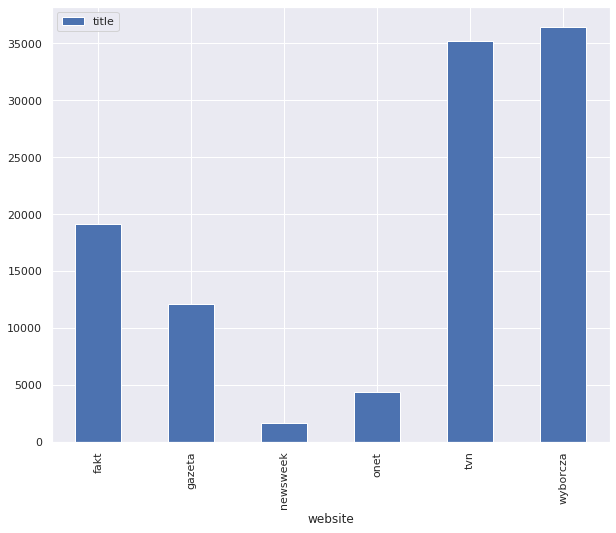

In [162]:
df\
    [['website', 'title']]\
    .groupby('website')\
    .count()\
    .plot(kind = 'bar')

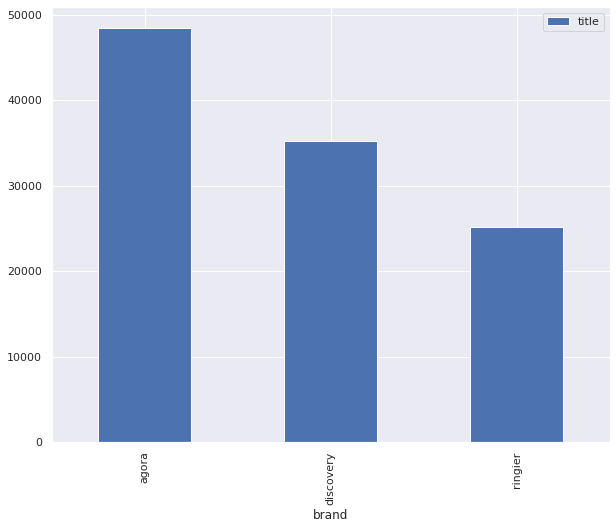

In [163]:
df\
    [['brand', 'title']]\
    .groupby('brand')\
    .count()\
    .plot(kind = 'bar')

# Analyze

## Get emotions data from polish wordnet

In [22]:
# http://plwordnet.pwr.wroc.pl//wordnet/download-wordnet?key=1iflsj&file=4.0
# extract one file (słownik_anotacji_emocjonlanej) to home directory

In [23]:
emotions = pd.read_csv('~/słownik_anotacji_emocjonlanej.csv')[['lemat', 'emocje']].dropna()

In [24]:
emotions.head()

,lemat,emocje
2,abstrakcyjny,wstręt;złość;zaskoczenie
3,abstrakcyjny,wstręt;złość
10,adorator,złość;radość
11,adorator,złość;cieszenie się na;radość;wstręt
18,afektowany,złość;smutek


In [25]:
emotions['emocje'] = emotions['emocje'].str.replace(':', ';')

In [26]:
pairs = [
    ('złosć', 'negatywny'),
    ('zlość', 'negatywny'),
    ('złośc', 'negatywny'),
    ('złość wstręt', 'negatywny'),
    ('złość: nieużyteczność', 'negatywny'),
    ('złóść', 'negatywny'),
    ('bład', 'negatywny'),
    ('brzydota', 'negatywny'),
    ('błąd', 'negatywny'),
    ('gniew', 'negatywny'),
    ('krzywda', 'negatywny'),
    ('nieszczęscie', 'negatywny'),
    ('nieszczęście', 'negatywny'),
    ('nieużyteczność', 'negatywny'),
    ('złość', 'negatywny'),
    ('strach', 'negatywny'),
    ('strach wstręt', 'negatywny'),
    ('smute', 'negatywny'),
    ('smutek', 'negatywny'),
    ('wstęt', 'negatywny'),
    ('niewiedza', 'negatywny'),
    ('negatywny wstręt', 'negatywny'),
    ('negatywnyk', 'negatywny'),
    ('negatywnyk: negatywny', 'negatywny'),
    ('wstrę', 'negatywny'),
    ('wstręt', 'negatywny'),
    ('wstręt: negatywny', 'negatywny'),
    ('negatywnyt', 'negatywny'),
    ('s mutek', 'negatywny'),
    ('wstret', 'negatywny'),
    ('smitek', 'negatywny'),
    (' negatywny', 'negatywny'),
    
    ('cieszenie sie', 'pozytywny'),
    ('cieszenie sie na', 'pozytywny'),
    ('cieszenie się na coś oczekiwanego', 'pozytywny'),
    ('dobro', 'pozytywny'),
    ('cieszenie sie', 'pozytywny'),
    ('radoć', 'pozytywny'),
    ('radość', 'pozytywny'),
    ('radość: piękno', 'pozytywny'),
    ('radość: szczęście', 'pozytywny'),
    ('zaufanie', 'pozytywny'),
    ('cieszenie się', 'pozytywny'),
    ('cieszenie się na', 'pozytywny'),
    ('ciesznie się na', 'pozytywny'),
    ('piękno', 'pozytywny'),
    ('pozytywny: piękno', 'pozytywny'),
    ('pozytywny: szczęście', 'pozytywny'),
    ('prawda', 'pozytywny'),
    ('radosć', 'pozytywny'),
    ('pozytywny: pozytywny', 'pozytywny'),
    ('radośc', 'pozytywny'),
    ('szczęście', 'pozytywny'),
    ('użyteczność', 'pozytywny'),
    ('wiedza', 'pozytywny'),
    ('zufanie', 'pozytywny'),
    ('pozytywny na', 'pozytywny'),
    (' pozytywny', 'pozytywny'),
    
    ('zaskoczenie czymś nieprzewidywanym', ''),
    ('oczekiwanie na', ''),
    (' czymś nieprzewidywanym', ''),
    ('-', ''),
    ('zaskoczenie', ''),
    ('pozytywnynegatywny', ''),
]

In [27]:
for pair in pairs:
    emotions['emocje'] = emotions['emocje'].str.replace(pair[0], pair[1])

In [28]:
emotions = pd.concat([
    emotions['lemat'],
    emotions['emocje']\
        .str.get_dummies(sep = ';')\
], axis = 1)

In [29]:
emotions.loc[
    emotions['pozytywny'] == emotions['negatywny']
, 'ambiguous'] = True

In [30]:
len(emotions)

56420

In [31]:
emotions = emotions[emotions['ambiguous'].isna()]
emotions = emotions.drop('ambiguous', axis = 1)

In [32]:
len(emotions)

47477

In [33]:
emotions['negatywny'].sum()

31505

In [34]:
emotions['pozytywny'].sum()

15972

In [35]:
emotions.sample(5).head()

,lemat,negatywny,pozytywny
107694,nieskwapliwość,0,1
154808,spokojniuchny,0,1
109344,subtelność,0,1
74825,uznaniowy,1,0
155569,kombinacyjnie,0,1


In [36]:
emotions = emotions.drop('negatywny', axis = 1)

In [37]:
emotions.loc[emotions['pozytywny'] == 0, 'pozytywny'] = -1

In [38]:
emotions.columns = ['lemat', 'sentyment']

In [39]:
emotions = emotions.drop_duplicates()

In [40]:
emotions.sample(5).head()

,lemat,sentyment
68449,letargiczny,-1
8470,wytłumaczyć,1
45315,człowiek wielkiego ducha,1
168779,fetyszystyczny,-1
27600,unifikator,1


In [41]:
emotions_dict = {x[0]:x[1] for x in emotions.values}

## Titles/shorts

In [42]:
emotions.sample(5).head()

,lemat,sentyment
161843,pośpieszyć,1
8634,zadra,-1
84046,niezły,1
131006,marzenie ściętej głowy,-1
44288,panienka spod latarni,-1


In [43]:
emotion_words = emotions_dict.keys()

In [44]:
df['sentiment'] = df['long'].str.lower().apply(lambda x: sum([emotions_dict[a] 
                                         for a in str(x).split(' ')
                                         if a in emotion_words]))

In [45]:
grouped_data = {}
for key, grouping_order in grouping_orders.items():
    data_dict = {}
    for keyword in keywords:
        data_dict[keyword] = df\
            [(df[keyword] == 1)&(df['sentiment'] != 0)]\
            [grouping_order['columns_before']]\
            .groupby(grouping_order['groupby'])\
            .mean()\
            .values\
            .flatten()
    res = pd.DataFrame().from_dict(
        data_dict,
        'index',
        columns = grouping_order['columns_after']
    )
    res = (res - res.mean())/res.std()
    grouped_data[key] = res

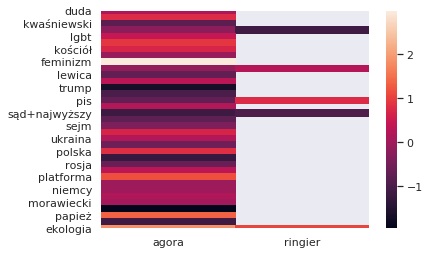

In [46]:
sns.heatmap(grouped_data['brand']);

In [47]:
# compare that chart (two websites in one company), and two websites from two different companies

## Regex

In [48]:
wc = WordCloud()

In [49]:
keyword_patterns = ['duda', 'dudy', 'dude']

In [50]:
found_records = df[['long']][
    df['long'].str.lower().str.contains(r'|'.join(keyword_patterns)) == True
].values.flatten()

In [51]:
keyword_words_before = []
keyword_words_after = []
for record in found_records:
    tmp_string_list = re.sub(r'\W+', ' ', record).lower().split(' ')
    keyword_idxs = [n for n, x in enumerate(tmp_string_list) if x in keyword_patterns]
    max_idx = len(tmp_string_list)
    for keyword_idx in keyword_idxs:
        if keyword_idx < max_idx - 2 and keyword_idx > 1:
            keyword_context_before = tmp_string_list[keyword_idx-2 : keyword_idx]
            keyword_words_before.append(keyword_context_before[0])
            keyword_words_before.append(keyword_context_before[1])
            keyword_context_after = tmp_string_list[keyword_idx+1 : keyword_idx+3]
            keyword_words_after.append(keyword_context_after[0])
            keyword_words_after.append(keyword_context_after[1])

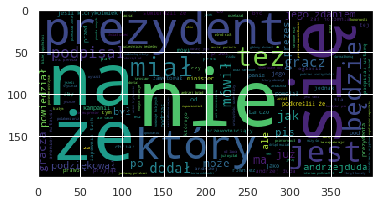

In [52]:
plt.imshow(wc.generate(" ".join(keyword_words_after)))

## Word2Vec

In [74]:
df['whole_string'] = (
    df['title'] + '. ' +
    df['short'] + '. ' +
    df['long']
)

In [75]:
def make_sentences(df):
    sentences = []
    for record in df['whole_string'].dropna().str.lower():
        if record != None:
            for sentence in record.split('.'):
                sentences.append(re.sub(r'\W+', ' ', sentence).lower().strip().split(' '))
    return sentences

In [86]:
models = {}
models['model'] = Word2Vec(make_sentences(df), min_count = 10, window = 5, workers = 10)
for country, brand_dict in brand_keys.items():
    models[country] = {}
    for brand_name in df['brand'].unique():
        models[country][brand_name] = {}
        brand_data = make_sentences(df[df['brand'] == brand_name])
        models[country][brand_name]['model'] = Word2Vec(brand_data, min_count = 10, window = 5, workers = 10)
#         for website_name in websites:
#             models[country][brand_name][website_name] = {}
#             website_data = make_sentences(df[df['website'] == website_name])
#             models[country][brand_name][website_name]['model'] = Word2Vec(website_data, min_count=10)

In [158]:
model_dict_keys = (
    ('us', 'discovery'),
    ('pl', 'agora'),
    ('de/ch', 'ringier')
)
results = []
df_idx = []
for keyword, reference in keyword_reference_words.items():
    if '' not in reference and '+' not in keyword:
        row = []
        for model_dict_key in model_dict_keys:
            #positive_dist = models[model_dict_key[0]][model_dict_key[1]]['model'].wv.distance(keyword, reference[0])
            #negative_dist = models[model_dict_key[0]][model_dict_key[1]]['model'].wv.distance(keyword, reference[1])
            keyword_vector = models[model_dict_key[0]][model_dict_key[1]]['model'].wv[keyword]
            positive_vector = models['model'].wv[reference[0]]
            negative_vector = models['model'].wv[reference[1]]
            positive_dist = distance.euclidean(keyword_vector, positive_vector)
            negative_dist = distance.euclidean(keyword_vector, negative_vector)
            score = negative_dist / (negative_dist + positive_dist)
            row.append(score)
        results.append(row)
        df_idx.append(keyword)

In [159]:
vector_results = pd.DataFrame(results, columns = ['discovery', 'agora', 'ringier'], index = df_idx)

In [160]:
vector_results

,discovery,agora,ringier
imigranci,0.350289,0.291255,0.369385
pis,0.461558,0.461888,0.471793
platforma,0.460830,0.459191,0.453144
lewica,0.609713,0.612603,0.628302
prawica,0.631381,0.633063,0.650357
europejska,0.552674,0.588397,0.571477
rosja,0.486425,0.511154,0.503156
stany,0.490854,0.522035,0.514046
opozycja,0.444595,0.442469,0.446516
rząd,0.470934,0.496127,0.489420


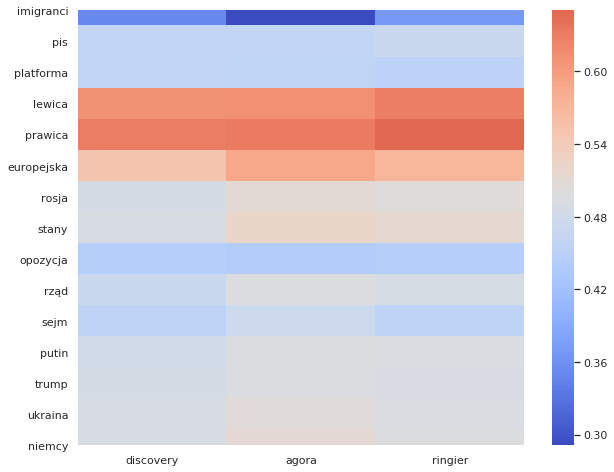

In [161]:
sns.heatmap(vector_results, cmap = 'coolwarm', center = 0.5)

array([ 6.78625286e-01,  7.50168085e-01, -7.70971775e-01, -5.05716801e-01,
        1.38321865e+00, -2.90895891e+00,  2.32455760e-01,  1.41240251e+00,
        6.13033958e-02, -8.06381881e-01, -2.41072536e-01, -3.20591474e+00,
       -3.13150811e+00,  1.14207840e+00,  2.94308352e+00,  2.30637521e-01,
       -8.21788236e-02, -8.77736866e-01, -1.63090396e+00,  6.39181256e-01,
       -1.10599077e+00, -1.74319589e+00, -6.78161502e-01, -1.71973431e+00,
        1.15525067e+00, -4.03502584e-01,  1.25215483e+00, -5.47323823e-01,
       -1.04449868e+00,  6.98796883e-02, -6.84220865e-02,  1.16684306e+00,
        2.87897766e-01, -1.81832516e+00, -2.82404590e+00,  5.64323485e-01,
        9.78835464e-01, -1.69431031e+00,  2.44143203e-01,  1.74163711e+00,
       -3.21861237e-01,  3.22285223e+00, -8.90608191e-01,  1.29519928e+00,
       -9.12600338e-01,  2.92637706e-01, -2.71832681e+00, -7.45588124e-01,
       -4.69883442e+00, -3.72346967e-01, -6.48278713e-01, -3.03471327e+00,
       -9.06940043e-01,  

## Convert to 2-d

In [77]:
models['pl']['model'].wv.similarity(keyword_reference_words['unia+europejska'], 'unia')

KeyError: 'pl'

In [ ]:
models['de/ch']['model'].wv.similarity(keyword_reference_words['unia+europejska'], 'unia')

In [ ]:
vectors = models['model'].wv.vectors
words = models['model'].wv.vocab

In [ ]:
pca = PCA(n_components = 100).fit(vectors)
plt.plot(np.cumsum(pca.explained_variance_ratio_));

In [94]:
pca_vectors = PCA(n_components = 90).fit_transform(vectors)

In [97]:
# tsne_vectors = TSNE(
#     n_components = 2, 
#     n_jobs = 10,
#     learning_rate = 200,
#     n_iter = 1500,
#     n_iter_without_progress = 100
# ).fit_transform(pca_vectors)

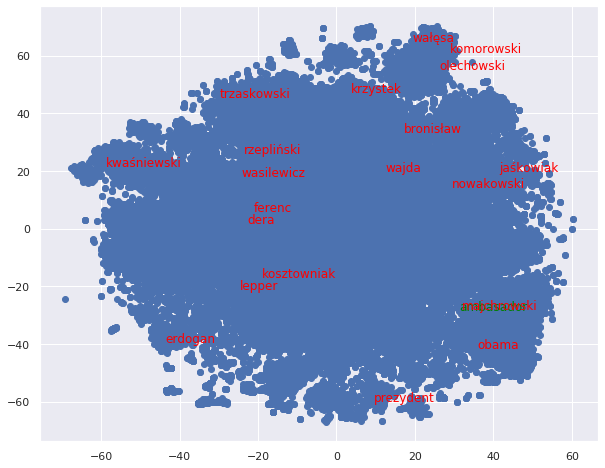

In [103]:
plt.plot(figsize = (12, 12))
plt.scatter(
    [x[0] for x in tsne_vectors],
    [x[1] for x in tsne_vectors],
)
selected_word = 'duda'
idx = list(models['model'].wv.vocab.keys()).index(selected_word)
plt.annotate(similar_word, (tsne_vectors[idx][0], tsne_vectors[idx][1]), color = 'green')
similar_words = [x[0] for x in models['model'].wv.most_similar(positive=[selected_word], topn=20)]
for similar_word in similar_words:
    idx = list(models['model'].wv.vocab.keys()).index(similar_word)
    plt.annotate(similar_word, (tsne_vectors[idx][0], tsne_vectors[idx][1]), color = 'red')

## Plot vector results

## Add keywords to wyborcza and gazeta

In [19]:
listdir('data/wyborcza_gazeta/urls')

['duda',
 'premier',
 'kwa%B6niewski',
 'imigranci',
 'lgbt',
 'bank',
 'ko%B6ci%F3%B3',
 'rydzyk',
 'feminizm',
 'emigracja',
 'lewica',
 'prezydent',
 'trump',
 'kaczy%F1ski',
 'pis',
 'stany',
 's%B1d+najwy%BFszy',
 'prawica',
 'sejm',
 'szyd%B3o',
 'ukraina',
 'opozycja',
 'polska',
 'leszek+miller',
 'rosja',
 'unia+europejska',
 'platforma',
 'rz%B1d',
 'niemcy',
 'media',
 'morawiecki',
 'putin',
 'papie%BF',
 'korwin',
 'ekologia']

In [20]:
decoder = {
    '%B1': 'ą',
    '%BF': 'ż',
    '%B3': 'ł',
    '%B6': 'ś',
    '%F1': 'ń',
    '%F3': 'ó'
}

In [21]:
keyword_urls = {}
keywords = []
for filename in listdir('data/wyborcza_gazeta/urls'):
    with open('data/wyborcza_gazeta/urls/'+filename, 'r') as f:
        urls = [x for x in f.read().split('\n') if 'gazeta.pl' in x or 'wyborcza.pl' in x]
        for key in decoder.keys():
            filename = filename.replace(key, decoder[key])
        keyword_urls[filename] = urls
        keywords.append(filename)

In [22]:
keywords_df = pd.concat([
    pd.DataFrame(
        pd.Series([1 for x in keyword_urls[key]], name = key, index = keyword_urls[key]),
    ) for key in keyword_urls.keys()  
], axis = 1, sort = False).fillna(0)

In [23]:
len(wyborcza_articles)

59662

In [24]:
wyborcza_articles = pd.merge(
    wyborcza_articles, 
    keywords_df, 
    left_on = 'url', 
    right_on = keywords_df.index
)

In [25]:
len(wyborcza_articles)

59477

In [26]:
len(gazeta_articles)

12590

In [27]:
gazeta_articles = pd.merge(
    gazeta_articles, 
    keywords_df, 
    left_on = 'url', 
    right_on = keywords_df.index
)

In [28]:
len(gazeta_articles)

12548

In [ ]:
## Add keywords to wyborcza and gazeta

listdir('data/wyborcza_gazeta/urls')

decoder = {
    '%B1': 'ą',
    '%BF': 'ż',
    '%B3': 'ł',
    '%B6': 'ś',
    '%F1': 'ń',
    '%F3': 'ó'
}

keyword_urls = {}
keywords = []
for filename in listdir('data/wyborcza_gazeta/urls'):
    with open('data/wyborcza_gazeta/urls/'+filename, 'r') as f:
        urls = [x for x in f.read().split('\n') if 'gazeta.pl' in x or 'wyborcza.pl' in x]
        for key in decoder.keys():
            filename = filename.replace(key, decoder[key])
        keyword_urls[filename] = urls
        keywords.append(filename)

keywords_df = pd.concat([
    pd.DataFrame(
        pd.Series([1 for x in keyword_urls[key]], name = key, index = keyword_urls[key]),
    ) for key in keyword_urls.keys()  
], axis = 1, sort = False).fillna(0)

len(wyborcza_articles)

wyborcza_articles = pd.merge(
    wyborcza_articles, 
    keywords_df, 
    left_on = 'url', 
    right_on = keywords_df.index
)

len(wyborcza_articles)

len(gazeta_articles)

gazeta_articles = pd.merge(
    gazeta_articles, 
    keywords_df, 
    left_on = 'url', 
    right_on = keywords_df.index
)

len(gazeta_articles)